In [99]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [100]:
words = open("names.txt", "r").read().splitlines()
words[:8] 

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [101]:
# Mapping characters from/to integer
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {s:i for i,s in stoi.items()}

In [ ]:
# Building the Dataset

block_size = 3
X, Y = [], []
for word in words[: 5]:
    context = [0] * block_size
    print(f"Word: {word}")
    for ch in word + ".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print("".join(itos[i] for i in context), " -> ", itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [103]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [104]:
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((27, 2), generator=g) # Embedding Table
emb = C[X]                # look up embeddings for all context chars
emb.shape

torch.Size([32, 3, 2])

In [105]:
# Define the first layer parameters
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)

In [106]:
# emb @ W1 + b1
# OUTPUT:-
# ---------------------------------------------------------------------------
# RuntimeError                              Traceback (most recent call last)
# Cell In[29], line 1
# ----> 1 emb @ W1 + b1

# RuntimeError: mat1 and mat2 shapes cannot be multiplied (48x2 and 6x100)

In [ ]:
# Inefficient as it creates additional memory.

# torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape # Specifically for block size 3.
torch.cat(torch.unbind(emb, 1), 1) # Genralized for block size.

In [ ]:
# tensor memory layout and reshaping example
# a = [i for i in range(18)]
a = torch.arange(18)
print(a.view(3,3,2))
print(a.view(2,9))
print(a.storage())

In [ ]:
emb.view(32, 6) == torch.cat(torch.unbind(emb, 1), 1) # Both produces identical results

In [ ]:
emb.view(32, 6) @ W1 + b1

In [ ]:
# h = emb.view(emb.shape[0], 6) @ W1 + b1
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h

In [112]:
h.shape

torch.Size([32, 100])

In [ ]:
# Define the parameters
W2 = torch.randn((100, 27), generator=g) 
b2 = torch.randn(27, generator=g)

In [114]:
logits = h @ W2 + b2

In [115]:
logits.shape

torch.Size([32, 27])

In [116]:
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdim=True)
# Log likelyhood loss
# loss = -prob[torch.arange(32), Y].log().mean()
# loss

# Better and efficient in forward and backward pass
# numerically stable
loss = F.cross_entropy(logits, Y)
loss

tensor(17.7697)

### Clean Code

In [153]:
# Using complete Dataset

def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for word in words:
        context = [0] * block_size
        for ch in word + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [154]:
# Splitting data
import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtst, Ytst = build_dataset(words[n2:])

In [200]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g) # Embedding Table
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g) 
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

sum(p.nelement() for p in parameters)

11897

In [201]:
for p in parameters:
    p.requires_grad = True

In [129]:
# This Code will take more time as it passes complete data per epoch, Time taken - 7m 26.4s
# Define parameters
LR = 0.1
EPOCH = 100

for _ in range(EPOCH):
 
    # Forward Pass
    emb = C[X] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)

    # Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    for p in parameters:
        p.data -= LR * p.grad

print(loss.item())

2.5609700679779053


In [ ]:
# # LR Exploration

# lre = torch.linspace(-3, 0, 1000)     # log10 scale: 1e-3 → 1e0
# lrs = 10 ** lre                       # convert to actual LR values
# lossi = []                            # to store loss values

# # Use in the main training loop
# for lr in lrs:
#     # ...
#     for p in parameters:
#         p.data += -lr * p.grad

# import matplotlib.pyplot as plt
# plt.plot(lre, lossi)
# plt.xlabel("log10(learning rate)")
# plt.ylabel("log10(loss)")
# plt.show()

In [202]:
# Define parameters
LR = 0.05
EPOCH = 200000
BATCH_SIZE = 64
DIMENSION = 10

lossi = []
stepi = []

In [203]:
# Using mini-batches for training, Time taken - 0.1s

for i in range(EPOCH):

    # Batch
    ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE, ))

    # Forward Pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 3 * DIMENSION) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    for p in parameters:
        p.data -= LR * p.grad

    stepi.append(i)
    lossi.append(loss.log10().item())

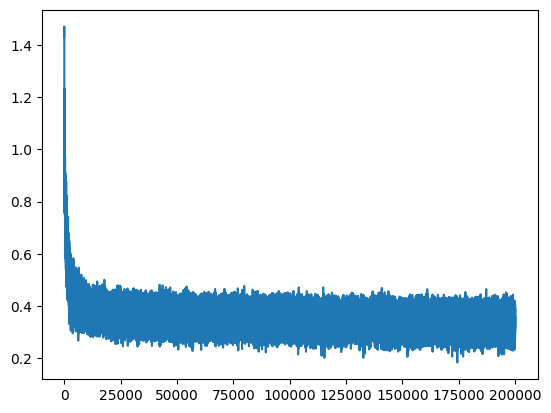

In [204]:
plt.plot(stepi, lossi)

In [205]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 3 * DIMENSION) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1742, grad_fn=<NllLossBackward0>)

In [206]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 3 * DIMENSION) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2032, grad_fn=<NllLossBackward0>)

In [215]:
for _ in range(5):
    output = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        output.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in output))

juel.
lure.
jirs.
taia.
abyriah.
